# A Chemical Classifier using a Computer Vision Classifier Model

Whilst completing lesson 1 of the [Fast.AI Deep Learning for Coders course](https://course.fast.ai), I was impressed by the examples of using image recognition for tasks not involving images. These included a student [beating the state-of-the-art enviromental sound detection by converting sounds to a spectrogram](https://etown.medium.com/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52), olive oil classification, and fraud detection. I was interested in see if I could use this technique with images of chemical structures to classify chemical compounds as either acidic, basic, neutral, or a zwitterion.

## Preparing the data

I used data kindly supplied by [Cambridge Medchem Consulting](https://www.macinchem.org/reviews/ipython/calcproperties2.php), a library of 17034 compounds, each with an ABNZ (acid, base, neutral, zwitterion) label. The file was loaded into a pandas dataframe using RDKit.

In [2]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools

In [3]:
df = PandasTools.LoadSDF('All_pKa_data.sdf')

[10:55:54] Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[10:55:54] ERROR: Could not sanitize molecule ending on line 1449941
[10:55:54] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[10:55:54] Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[10:55:54] ERROR: Could not sanitize molecule ending on line 1450328
[10:55:54] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33


Each entry had a lot of information, but for this classifier I only wanted the SMILES string and its ABNZ assignment.

In [4]:
df.columns

Index(['Name', 'NON_CHIRAL_CANONICAL_SMILES', 'STANDARD_SMILES', 'acid-base',
       'group', 'pka', 'pka_method', 'type', 'has_tautomer', 'has_duplicate',
       'has_stereoisomer', 'pka_list', 'ABNZ', 'id', 'apKa1', 'SMILES',
       'aroatoms_count', 'aromC_count', 'benzene_count', 'acetylene_count',
       'Allene_count', 'carbonyl_count', 'amide_count', 'PriAmide_count',
       'Lactam_count', 'urea_count', 'acid_count', 'acidHalide_count',
       'hyroxamic_count', 'ester_count', 'lactone_count', 'anhydride_count',
       'aldehyde_count', 'ketone_count', 'Unsatcarbonyl_count', 'ketene_count',
       'nitro_count', 'nitrile_count', 'oxime_count', 'Noxide_count',
       'quat_count', 'Narom_count', 'priAmine_count', 'secAmine_count',
       'tertAmine_count', 'aniline_count', 'Imine_count',
       'ImidoylHalide_count', 'amidine_count', 'guanidine_count',
       'Hydrazones_count', 'Semicarbazones_count', 'Diazo_count',
       'Isonitriles_count', 'Isocyanates_count', 'hydrox_count

In [5]:
data_clean = df[["STANDARD_SMILES","ABNZ"]].copy()

Whilst not completely balanced, there was plenty of examples of each type of compound. Balancing these using data augmentation may improve the model, but at this stage I just wanted to see if it would work at all.

In [6]:
data_clean.ABNZ.value_counts()

Neutral       6974
Base          5446
Acid          3478
Zwitterion    1136
Name: ABNZ, dtype: int64

In [7]:
data_clean.shape
# 17034 compounds

(17034, 2)

In [8]:
data_clean.isna().sum()
# No missing values

STANDARD_SMILES    0
ABNZ               0
dtype: int64

In [18]:
data_clean.STANDARD_SMILES.duplicated().sum()
# Some duplicates

0

In [15]:
# Checking for duplicates with conflicts
smiles_conflict = []
idx_conflict = []

for smiles in data_clean['STANDARD_SMILES'].unique() :

    
    outcomes = data_clean[ data_clean.STANDARD_SMILES == smiles ].ABNZ.unique()
    
    if len(outcomes) > 1 :
        
        idx_tmp = data_clean.index[ data_clean.STANDARD_SMILES == smiles ].tolist()
        idx_conflict.extend(idx_tmp)
        smiles_conflict.append(smiles)

print("#", len(smiles_conflict), "SMILES strings with conflicting activities, associated with", len(idx_conflict), "entries.")

# 27 SMILES strings with conflicting activities, associated with 77 entries.


In [16]:
# Removing conflicts
data_clean = data_clean.drop(idx_conflict)

In [17]:
data_clean = data_clean.drop_duplicates(subset='STANDARD_SMILES')  # remove duplicate rows except for the first occurring row.
data_clean.ABNZ.value_counts()

Neutral       5622
Base          3922
Acid          2694
Zwitterion     603
Name: ABNZ, dtype: int64

For each compound, I used RDKit to create an RDKit object from the SMILES string, created an image of the structure, and saved in a folder assigned by its ABNZ label.

In [20]:
mol_list = [Chem.MolFromSmiles(x) for x in data_clean.STANDARD_SMILES]
data_clean['mol'] = mol_list

In [21]:
for index, row in data_clean.iterrows():
    ABNZ = row.ABNZ
    Chem.Draw.MolToFile(row.mol, f'./learning_images/{ABNZ}/{index}.png')    

,STANDARD_SMILES,ABNZ,mol
1155,C[n+]1cccc2c(S)cccc21,Acid,

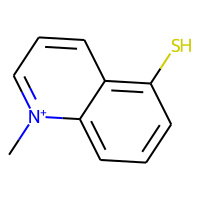

In [22]:
data_clean.sample(1)

## Building the model

With plenty of data, it was now time to train the model. The FastAI library makes training a CNN ridiculously easy. I first created a DataLoaders object which creates the training and validation sets, using a DataBlock.
The parameters needed are: 
* blocks: this specifies that out inputs are images, and the outputs are categories
* get_items: this collects the images
* splitter: splits the data into a training and validation set
* get_y: this labels the images according the the name of the folder they are saved in
* item_tfms: squishes the images to 192x192 pixels

We can then view a sample of the data used for training.

In [1]:
from fastai.vision.all import *

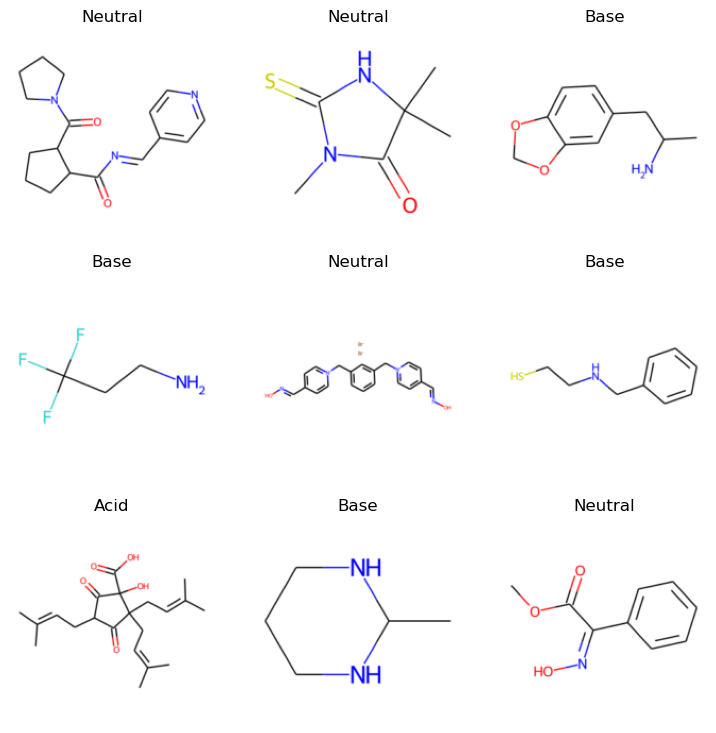

In [2]:
# Specify where to find the images to use for training the model
path = "./learning_images"

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, num_workers=0)

dls.show_batch(max_n=9)

Training our model is easy. FastAI has a fine_tune method which does it all for us. To begin with I'm using a fast, widely-used computer vision model called resnet18.

In [3]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

/Users/jonswain/miniforge3/envs/rdkit-fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jonswain/miniforge3/envs/rdkit-fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.400215,0.933419,0.377726,01:35


epoch,train_loss,valid_loss,error_rate,time
0,0.858623,0.656120,0.251947,01:52
1,0.591135,0.570945,0.218847,01:50
2,0.416128,0.591331,0.213785,02:09
3,0.322505,0.589854,0.201324,02:04
4,0.262273,0.592558,0.200545,02:09
5,0.203819,0.622118,0.193925,02:06
6,0.176672,0.632959,0.177960,02:11
7,0.117514,0.613399,0.167445,02:12
8,0.111624,0.711667,0.179517,02:17
9,0.086128,0.788115,0.192757,02:16


Even this simple model is 85% accurate as predicting ABNZ for chemical compounds. With significantly fewer zwitterions in the data set it's no surprise it struggles to identify them.
It's not perfect, but does a good job with simple comounds. A few examples are shown below:

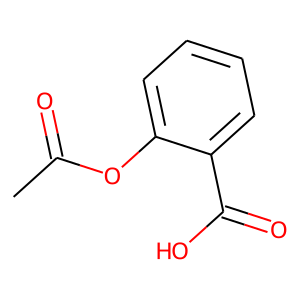

This is a: Acid.
Probability: 0.9998


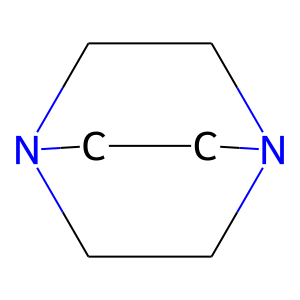

This is a: Base.
Probability: 1.0000


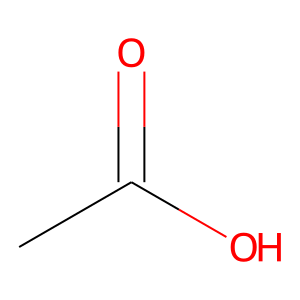

This is a: Acid.
Probability: 1.0000


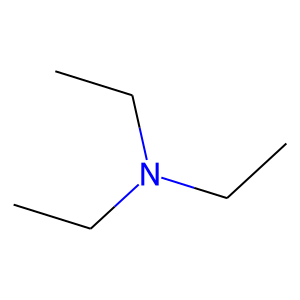

This is a: Base.
Probability: 0.9999


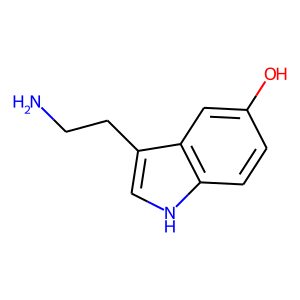

This is a: Base.
Probability: 1.0000


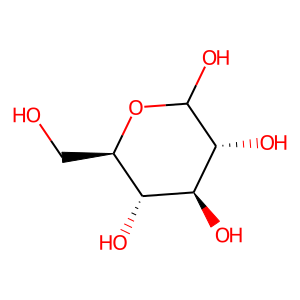

This is a: Neutral.
Probability: 0.9487


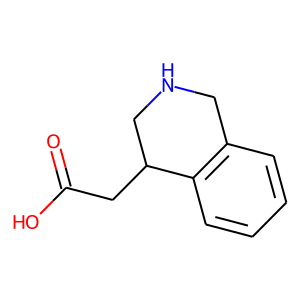

This is a: Acid.
Probability: 0.7467


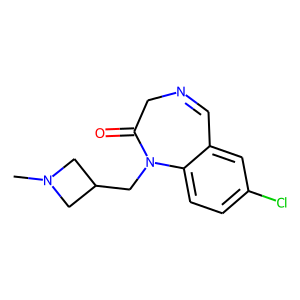

This is a: Neutral.
Probability: 0.9990


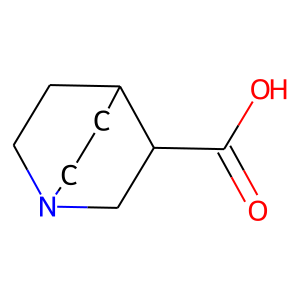

This is a: Base.
Probability: 0.7441


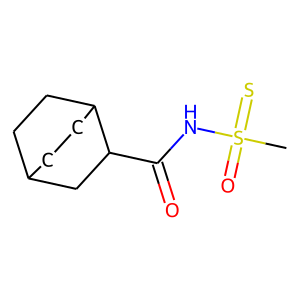

This is a: Acid.
Probability: 0.9995


In [4]:
from PIL import Image

for count in range(0,10):
    category,_,probs = learn.predict(PILImage.create(f'./test/{count}.png'))
    image = Image.open(f'./test/{count}.png')
    display(image)
    print(f"This is a: {category}.")
    print(f"Probability: {probs[_]:.4f}")

A look at the confusion matrix shows that the model very rarely gets acids and bases confused with eachother, but makes more mistakes classifying compounds at neutral when they aren't, or incorrectly classifying neutral compounds as acids or bases. This is fairly expected.

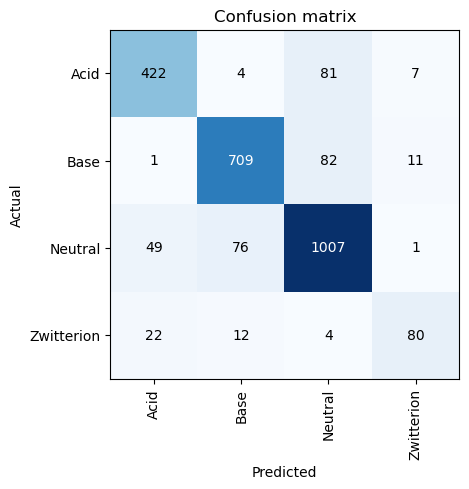

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We can also look at the 10 biggest mistakes the model makes:

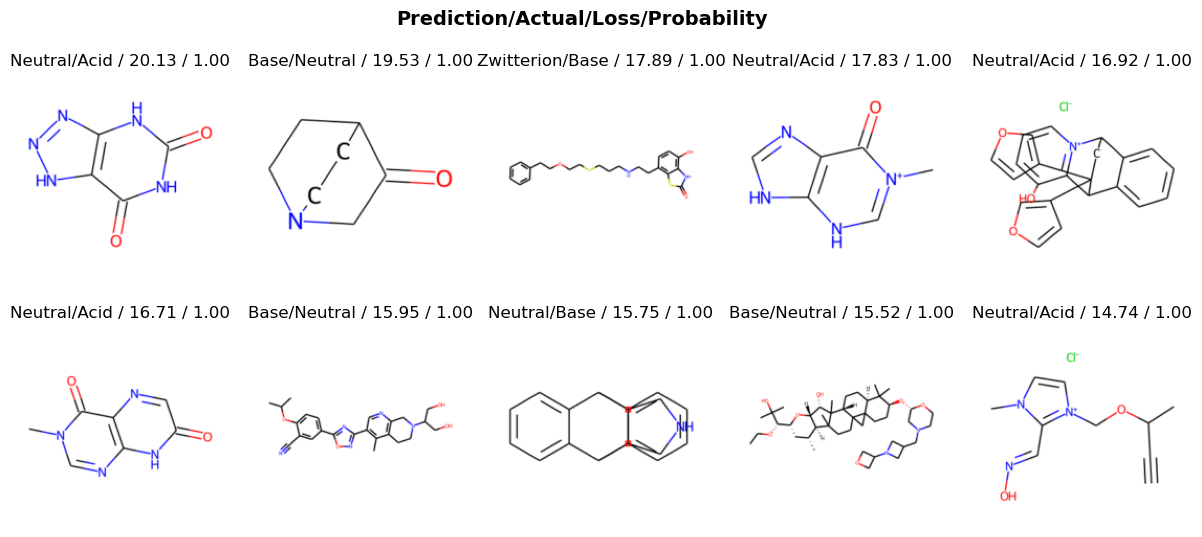

In [6]:
interp.plot_top_losses(10, nrows=2)